<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/12-clustering/Week_12_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science and Machine Learning - Week 11
# Clustering

This is an unsupervised learning algorithm (i.e., we have unlabelled data). The objectives of clustering are:
* to organise the data into classes so that there is a high degree of intra-class similarity and a low degree of inter-class similarity
* to find the class labels and the number of classes
directly from the data (in contrast to
classification where the algortihm learned used labelled data).
* to find natural groupings between objects.

<img src='https://miro.medium.com/v2/resize:fit:4800/format:webp/0*ZxLMBwq9rmW9ZFuZ.jpg' width="800">

Source: [The difference between supervised and unsupervised learning](https://twitter.com/athena_schools/status/1063013435779223553), illustrated by [@Ciaraioch](https://twitter.com/Ciaraioch) 


There are two types of clustering:
* Partitioning algorithms (for example, k-means)
* Hierarchical clustering

In this lab session we implement and compare them.
#todo:
switch start with hieratchical
how to go to embedings, go to survey try cosine 

### **Table of Contents**

#### **1. Basic Examples**
- **1.1**: K-means in 1 Dimension  
- **1.2**: Hierarchical Clustering  

#### **2. Runtime Complexity Comparison Exercise**  
- **2.1**: Generate 3 Clusters for Different Numbers of Points  
- **2.2**: Compare Runtime of K-means and Hierarchical Clustering  
- **2.3**: Plot Execution Time vs. Number of Points  

#### **3. Customer Segmentation**  
- **3.1**: Load, Prepare, and Explore Data  
- **3.2**: K-means Algorithms  
- **3.3**: Hierarchical Clustering  

#### **4. Clustering vs. Classification**  
- **4.1**: Load Data  
- **4.2**: Algorithms Comparison: K-means vs. Logistic Regression  

#### **5. Feedbacks from the Previous Year**  
- **5.1**: Can You Spot Clusters in the Data?  
- **5.2**: What Linkages Do the Clusters Have?  

In [1]:

# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as sch

# Customize plots
%matplotlib inline
try:
    plt.style.use("seaborn-deep")
except:
    pass

# What other styles are available
#plt.style.available

## 1. Basic Examples
As always, we first go through basic examples to visualize and understand what happens.


### 1.1 K-means in 1 dimension

We first look at a sample data set of students grades.


In [2]:
# Load data
grades = pd.read_csv("https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/12-clustering/data/student_grades.csv")
print(f"There are {len(grades)} observations.")
grades.head()

There are 36 observations.


,Course total (Real)
0,80.35
1,86.67
2,72.77
3,87.55
4,73.00


<Axes: xlabel='Course total (Real)', ylabel='Count'>

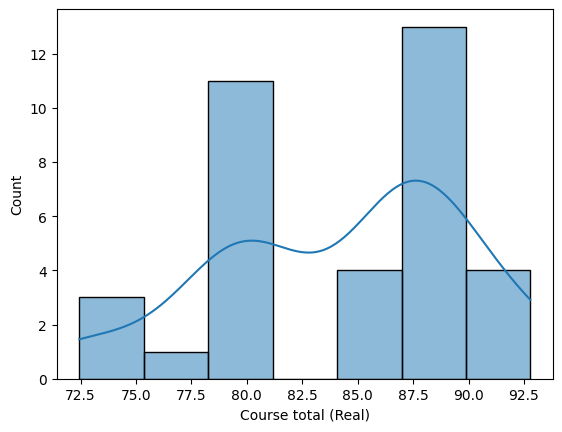

In [3]:
sns.histplot(grades['Course total (Real)'], kde=True)

There are observations are between 72 and 92 approximately. One way to visualise the clusters is by plotting them in a one dimension scatterplot (one dimension because we only ave one feature=the grades).

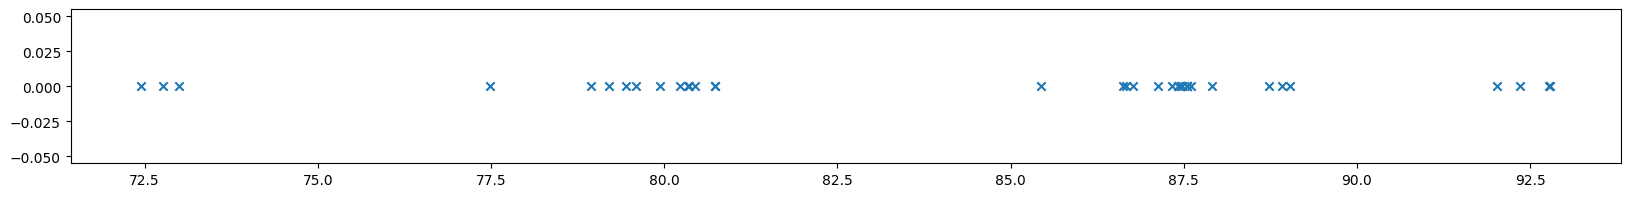

In [4]:
# Plot the grades
plt.figure(figsize=(20,2))
plt.scatter(grades, np.zeros_like(grades), marker='x')

We clearly see 4 clusters in our sample dataset:
* around 72.5 are the lowest grades
* around 80 are the normal grades
* around 87.5 are the good grades
* around 92.5 are the highest grades

We now fit a K-Means algortim with different k's (i.e. number of clusters). The documentation file can be found [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

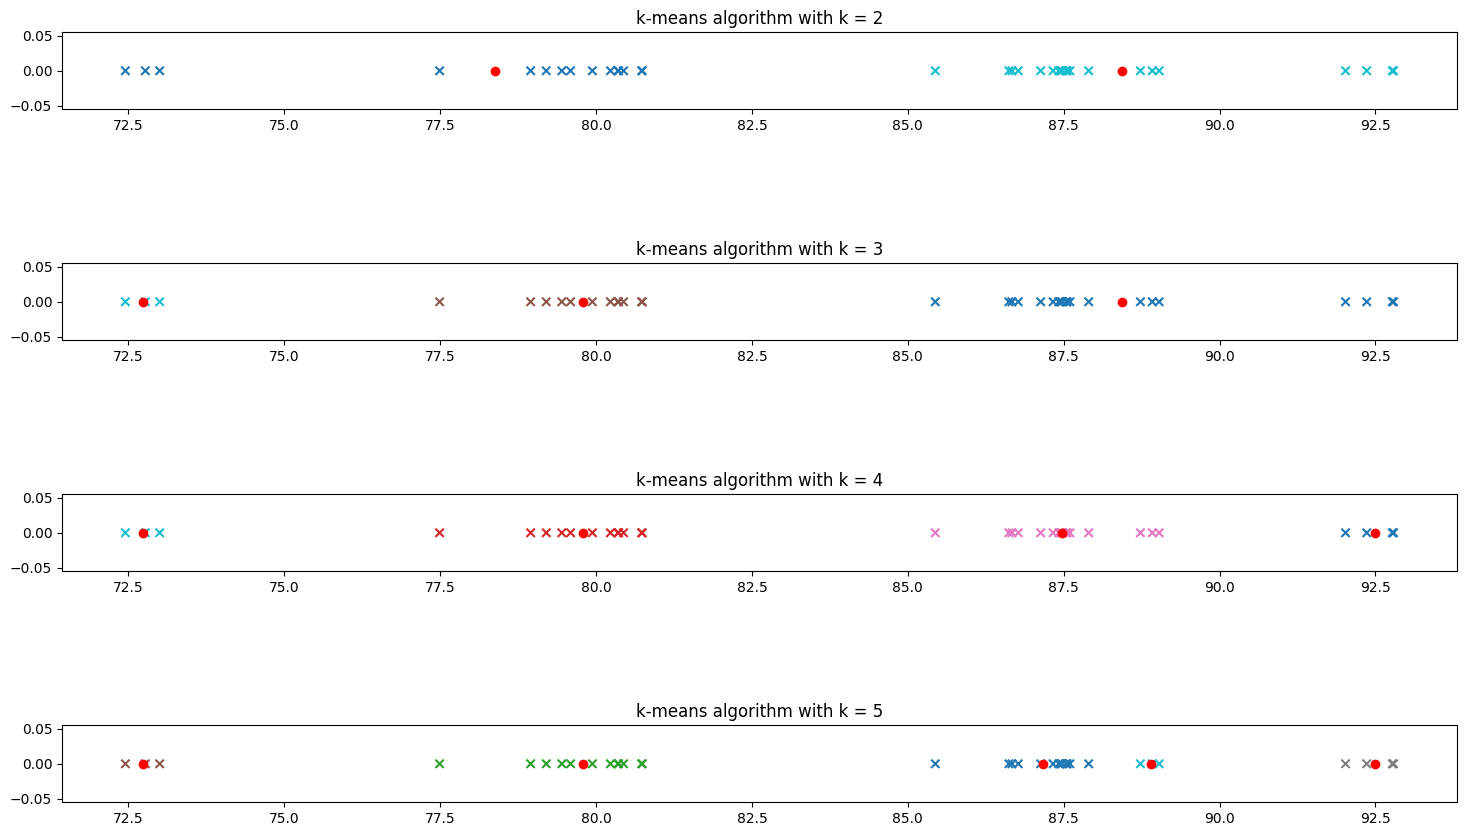

In [5]:
# Fit k-means algorithm for different k
fig, ax = plt.subplots(4, 1, figsize=(18, 10))

for i, k in enumerate([2, 3, 4, 5]):
    # Create instance of class with n_init explicitly set
    model = KMeans(n_clusters=k, n_init=10)
    # Fit model
    model.fit(grades)
    # Get centers of clusters
    centers = model.cluster_centers_
    # Get predictions (we use only the grades)
    pred = model.predict(grades)
    # Plot the points, colored by associated cluster
    ax[i].scatter(grades, np.zeros_like(grades), marker='x', c=pred, cmap='tab10')
    # Plot the center of each cluster
    ax[i].scatter(centers, np.zeros_like(centers), color='red')
    ax[i].set_title('k-means algorithm with k = ' + str(k))

plt.subplots_adjust(hspace=2)
plt.show()


With 2 clusters, it already works well. We could then label students as `good` and `not so good` for example.   
However, at least visually, it seems it works best with 4 clusters.  
In order to find out the optimal number of groups, we can plot the the objective/cost function of the algorithm vs the values of `k`. The point where we see an __"elbow"__, i.e, the cost value almost remains the same by further increasing the `k`, could be an appropriate choice for the optimal value of `k`. 

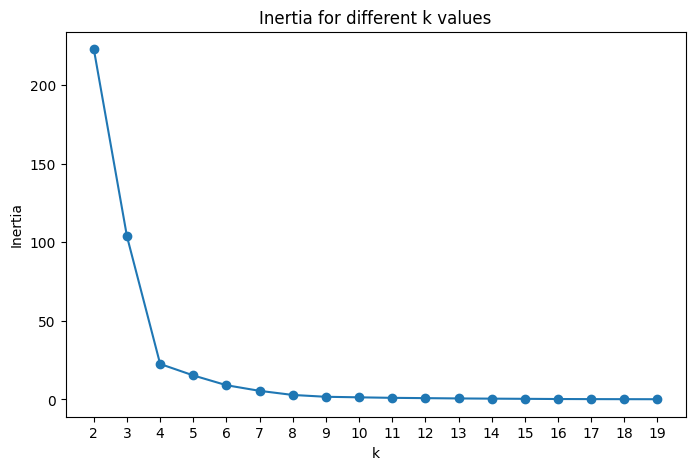

In [6]:
# Initialize inertia list
inertia = []

# Define range of k values
k_values = range(2, 20)

# Fit k-means algorithm for each k
for k in k_values:
    # Set n_init explicitly to suppress the warning
    model = KMeans(n_clusters=k, n_init=10)
    # Fit the model
    model.fit(grades)
    # Append inertia
    inertia.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='solid')
plt.title('Inertia for different k values')
plt.ylabel('Inertia')
plt.xlabel('k')
plt.xticks(np.arange(min(k_values), max(k_values) + 1, step=1))
plt.show()


In this case, 4 is the optimal number of clusters. The `inertia` is defined as the sum of squared distances of each sample to their closest cluster center. This is the cost function that the algorithm minimizes. From k=5 we see that the reduction in the cost function is much lower than for example for k=1.

### 1.2 Hierarchical clustering
In order to show how it works, we use a small set of 9 points.

In [7]:
# Create Data
data = {
    "p":["p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8"],
    "x1":[0.84, 0.15, 0.87, 0.90, 0.93, 0.88, 0.87, 0.12, 0.91],
    "x2":[0.91, 0.15, 0.47, 0.54, 0.84, 0.51, 0.86, 0.18, 0.73]}

data = pd.DataFrame(data)
data

,p,x1,x2
0,p0,0.84,0.91
1,p1,0.15,0.15
2,p2,0.87,0.47
3,p3,0.90,0.54
4,p4,0.93,0.84
5,p5,0.88,0.51
6,p6,0.87,0.86
7,p7,0.12,0.18
8,p8,0.91,0.73


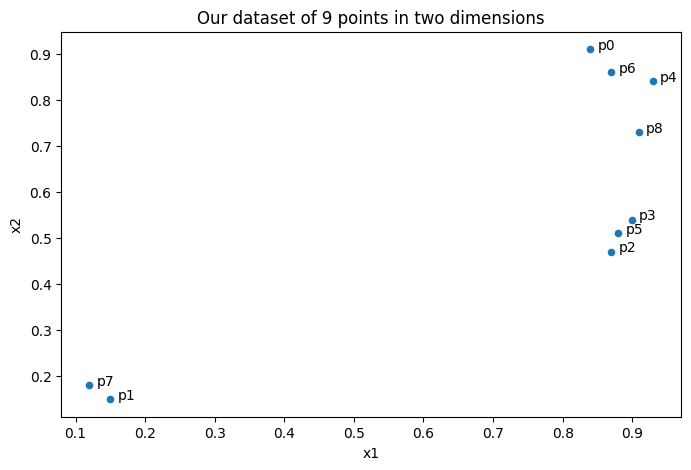

In [8]:
# Plot
data.plot.scatter("x1", "x2", figsize=(8, 5))
plt.title("Our dataset of 9 points in two dimensions")
for point in data.values:
  plt.text(point[1]+0.01, point[2], point[0])

In this case, there are 2 or 3 clusters. We can further compute the euclidean distances between the points.

<Axes: >

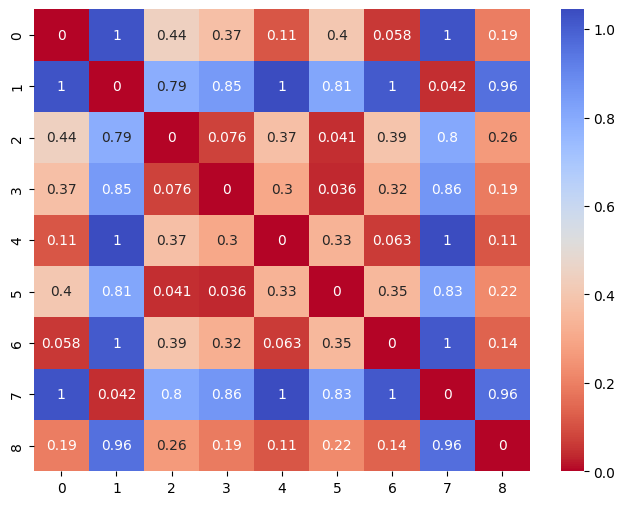

In [9]:
# Show distances
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(pairwise_distances(data[["x1", "x2"]], metric='euclidean')), annot=True, cmap='coolwarm_r', fmt='.2g')

For example `p0` is:
* close to p6, p4, p8 (distance close to 0, here red)
* a little further away from p3, p5, p2
* far from p1, p7 (distance close to 1, here blue)

Now we plot our dendrograms using the [Scipy hierarchical clustering functions](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

The first dendrogram uses as a metric the Euclidean distance between observations and the signle method linkage (considers the minimum distance between observations belonging to the clusters).

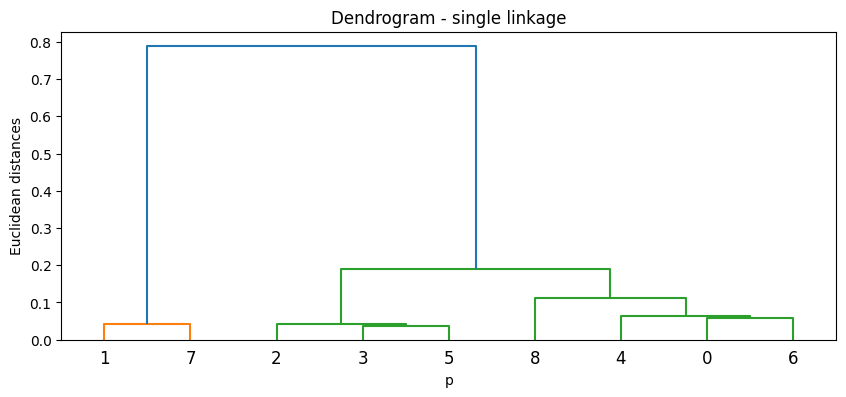

In [10]:
# Plot dendrogram, first with linkage = 'single'
plt.figure(figsize=(10,4))
dendrogram = sch.dendrogram(sch.linkage(data[["x1", "x2"]], method = 'single', metric='euclidean'))
plt.title('Dendrogram - single linkage')
plt.xlabel('p')
plt.ylabel('Euclidean distances')
plt.show()

With `single linkage`, we can see that `p0` is first attached to `p6`, then both of them are attached to `p4`, and finally the these three points are attached to `p8`. This is the first cluster. The resulting number of clusters depends on where we cut the dendrogram, as shown below. With 2 clusters we have: {p1, p7} and {p2, p3, p5, p8, p4, p0, p6} and with 3 clusters we have: {p1, p7}, {p2, p3, p5} and {p8, p4, p0, p6}.

For the second dendrogram we use the `complete` linkage which looks at the maximum distance between observations belonging to the clusters. This forces clusters to be more separated. 

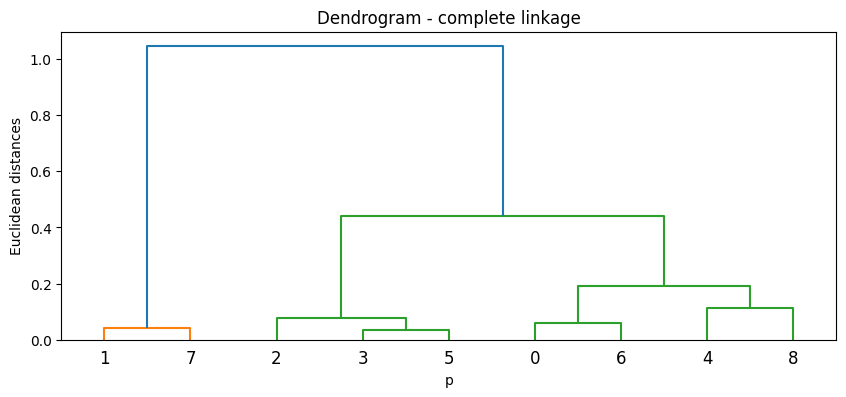

In [11]:
# Plot dendrogram, now with linkage = 'complete'
plt.figure(figsize=(10,4))
dendrogram = sch.dendrogram(sch.linkage(data[["x1", "x2"]], method = 'complete', metric='euclidean'))
plt.title('Dendrogram - complete linkage')
plt.xlabel('p')
plt.ylabel('Euclidean distances')
plt.show()

With `complete linkage`, p0 is first attached to p6 and p4 to p8. Then the two groups are combined to form a superset. This is because p4 and p8 are closer to each other than to the max distance to p0 or p6.

For more documentation on the other linkage methods that you can use with the Scipy functions, you can see the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

From sklearn we can use the [Agglomerative Clustering function](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), where we can define the number of clusers, the metric to be used for distances and the linkage method as shown below.

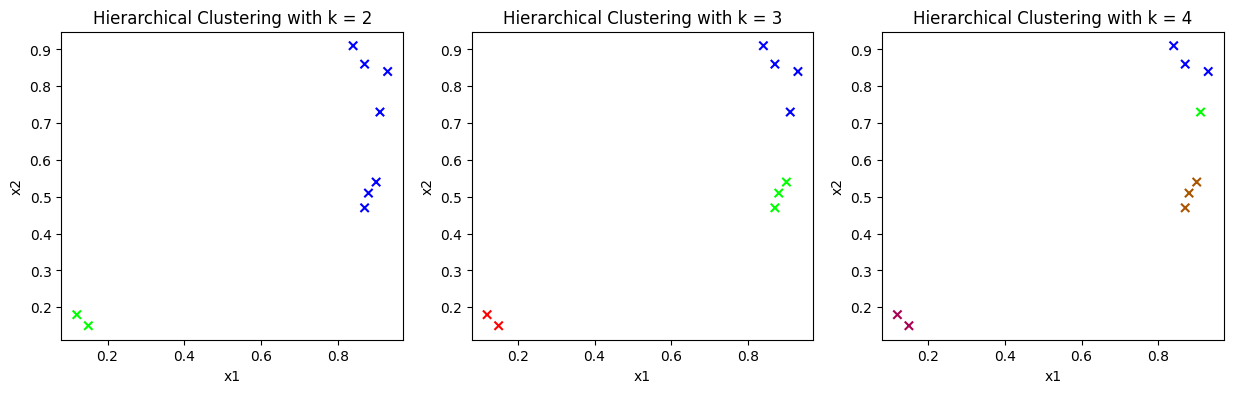

In [12]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Plot with different number of clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, k in enumerate([2, 3, 4]):
    # Update to use 'metric' instead of 'affinity'
    clustering = AgglomerativeClustering(n_clusters=k, linkage='single', metric='euclidean')
    assignment = clustering.fit_predict(data[["x1", "x2"]])
    ax[i].scatter(data["x1"], data["x2"], marker='x', c=assignment, cmap='brg')
    ax[i].set_title(f'Hierarchical Clustering with k = {k}')
    ax[i].set_xlabel("x1")
    ax[i].set_ylabel("x2")

plt.subplots_adjust(hspace=0.3)
plt.show()


We see that k = 2 and k = 3 is fine. However, k = 4 might be overdoing it in this case.

## 2. Runtime complexity comparison exercise


We want to compare the computation time needed between **Kmeans** and **Hierarchial clustering** for different numbers of points.



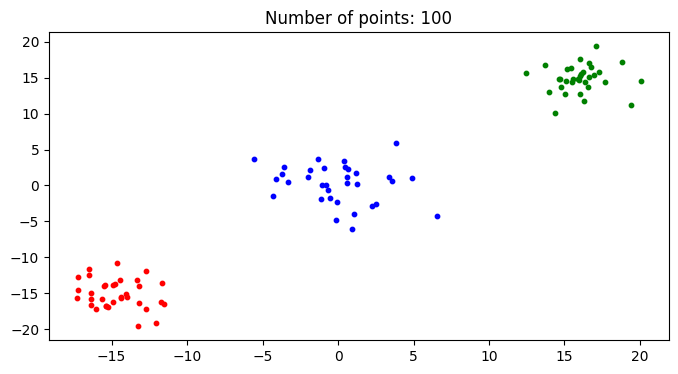

In [13]:
# We create a function that generates 3 clusters
def generate_three_clusters(num_points):
  centers = [(-15, -15), (0, 0), (15, 15)]
  cluster_std = [2, 3, 2]
  X, y = make_blobs(n_samples=num_points, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)
  return X, y

# Example with 100 points
X, y = generate_three_clusters(100)
# Plot clusters
plt.figure(figsize=(8,4))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10)
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10)
plt.title('Number of points: 100')
plt.show()

### 2.1 Generating 3 Clusters for Different Numbers of Points

We can use the previously defined clustering function to generate datasets with 3 clusters for various sample sizes. Specifically, we'll generate clusters for `n = 100`, `1000`, `2500`, `5000`, `7500`, `10000`, and `25000` points. Then, we store the resulting datasets in a list called `X_list`. This allows us to compare clustering performance across datasets of increasing size.

In [14]:
# Define list
X_list = []
# Define numbers of points
num_points = [100, 1000, 2500, 5000, 7500, 10000, 25000]

for n in num_points:
  # Generate three clusters
  X, y = generate_three_clusters(n)

  # Append X to X_list
  X_list.append(X)

In [15]:
X_list[0].shape

(100, 2)

### 2.2 For all samples of points, fit a k-means algorithm and a hierarchical clustering algorithm and record the completion time. 

We use the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) classes, both configured with 3 clusters. Then we record the time it takes to fit each algorithm using the `time` package, as shown in the example below. This will help compare the efficiency of the two clustering methods across datasets of different sizes.

In [16]:
# Example with the time package
import time
start = time.time()
for i in range(10000000):
  a = 1 + 1 # do something
end = time.time()
print('Start: ' + str(start))
print('End: ' + str(end))
print('Time: ' + str(end-start))

Start: 1733149414.486576
End: 1733149415.013607
Time: 0.5270309448242188


In [17]:
import time
from sklearn.cluster import KMeans, AgglomerativeClustering

# Record time in lists
k_means_time = []
hc_time = []

for X in X_list:
    # Create instance of KMeans class (with 3 clusters) and set `n_init`
    model = KMeans(n_clusters=3, n_init=10)

    # Fit the model on X and record the time to fit
    start = time.time()
    model.fit(X)
    end = time.time()

    # Store the execution time in k_means_time
    k_means_time.append(end - start)

    # Create instance of AgglomerativeClustering class (with 3 clusters)
    model = AgglomerativeClustering(n_clusters=3)

    # Fit the model on X and record the time to fit
    start = time.time()
    model.fit(X)
    end = time.time()

    # Store the execution time in hc_time
    hc_time.append(end - start)


### 2.3 Plot the execution time vs. number of points for k-means and hierarchical clustering
We plot the execution time against the number of points for both k-means and hierarchical clustering. This visualization allows us to clearly observe how the runtime of each algorithm scales with the size of the dataset and compare their computational efficiency.

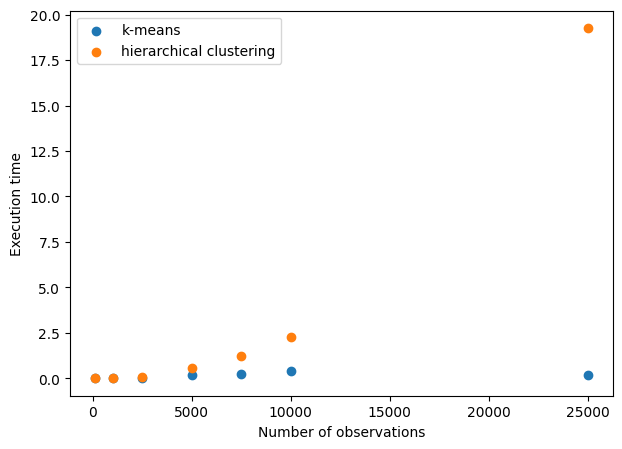

In [18]:
plt.figure(figsize=(7,5))
plt.scatter(num_points, k_means_time, label='k-means')
plt.scatter(num_points, hc_time, label='hierarchical clustering')
plt.ylabel('Execution time')
plt.xlabel('Number of observations')
plt.legend()
plt.show()

## 3. Customer segmentation
We now implement customer segmentation with the two algorithms. The data set can be found in Kaggle [here](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

### 3.1 Load, prepare, and explore data

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/12-clustering/data/Mall_Customers.csv', index_col=0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


We have 200 customers with their gender, age, annual income, and spending score.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [21]:
# Convert Gender to numerical
df.Gender = df.Gender.astype('category').cat.codes
df.Gender.value_counts()

Gender
0    112
1     88
Name: count, dtype: int64

In this case 0 corresponds to female customers.

In [22]:
df.describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [23]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

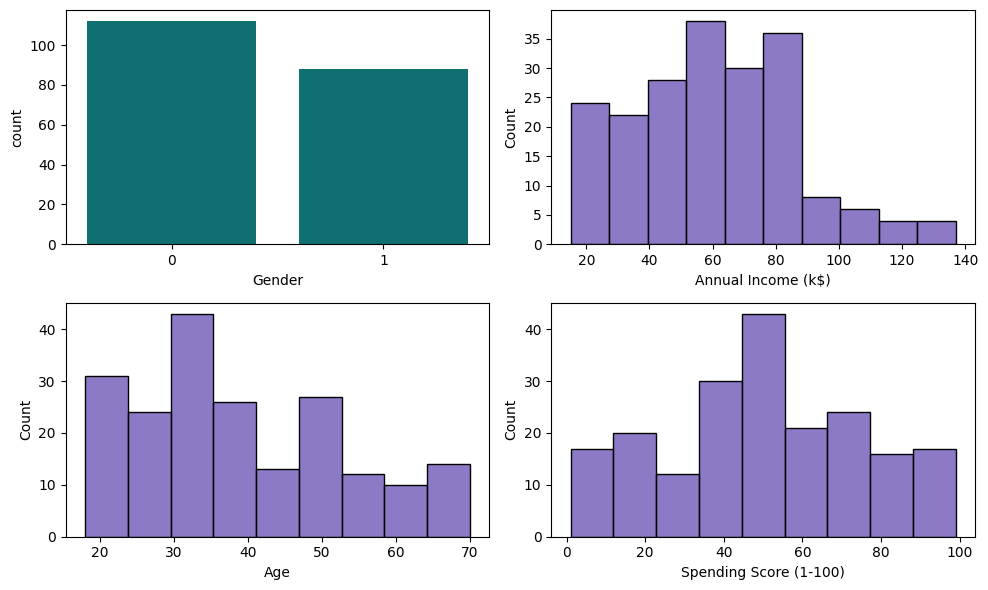

In [24]:
# Univariate Analysis
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
i = 0
j = 0
for var in df:
    if var == "Gender":
        # Use color instead of palette, or assign hue
        sns.countplot(x=df[var], ax=ax[i, j], color="teal")  # Replace 'palette' with 'color'
    else:
        sns.histplot(df[var], ax=ax[i, j], color=(0.4, 0.3, 0.7))
    i += 1
    if i == 2:
        i = 0
        j += 1

plt.tight_layout()  # Improve layout for better visualization
plt.show()

<Figure size 1000x600 with 0 Axes>

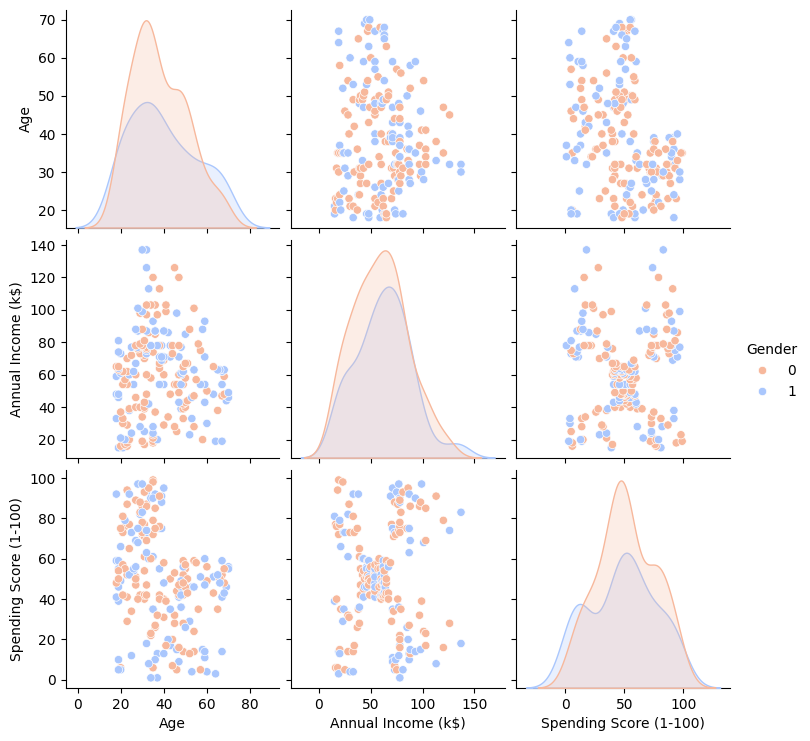

In [25]:
# Bivariate Analysis
plt.figure(figsize=(10,6))
sns.pairplot(df, hue='Gender', palette="coolwarm_r")

Using `Annual Income` and `Spending Score`, we can observe 5 clusters.

### 3.2 k-means algorithm
Again, we first want to find out the good number of clusters.

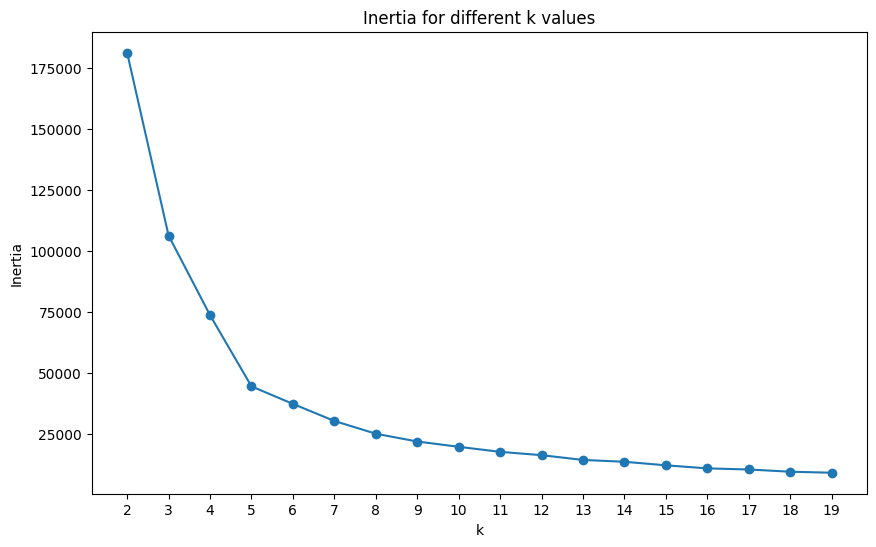

In [26]:

# Function to plot inertia
def k_means_inertia_plot(variables):
    # Create new dataframe
    new_df = df[variables]

    # Fit k-means algorithm for different k
    inertia = []
    k_values = range(2, 20)
    for k in k_values:
        model = KMeans(n_clusters=k, n_init=10)  # Set n_init explicitly
        model.fit(new_df)
        inertia.append(model.inertia_)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia, marker='o', linestyle='solid')
    plt.title('Inertia for different k values')
    plt.ylabel('Inertia')
    plt.xlabel('k')
    plt.xticks(np.arange(min(k_values), max(k_values) + 1, step=1))
    plt.show()

# Use function - two variables
k_means_inertia_plot(["Annual Income (k$)", "Spending Score (1-100)"])

This confirms what we saw in the EDA. Using these two variables, 5 clusters are optimal.

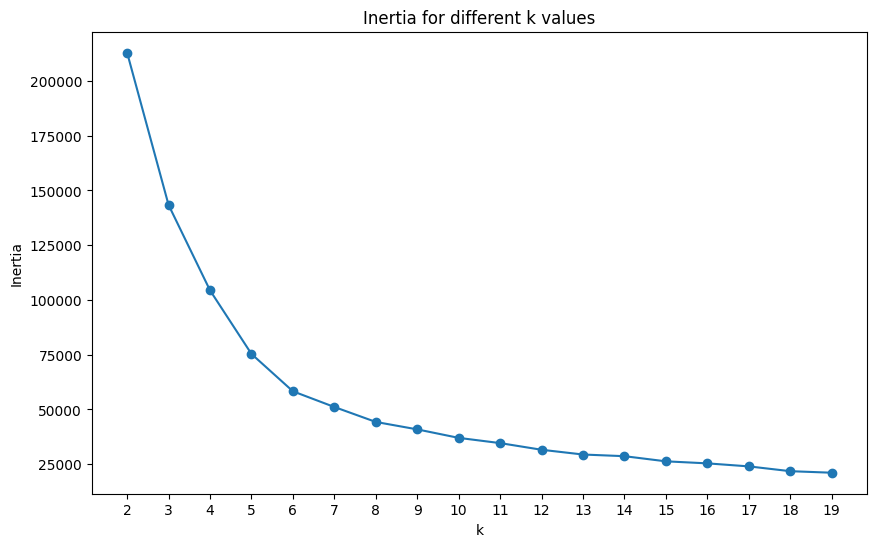

In [27]:

# Use function - three variables
k_means_inertia_plot(["Annual Income (k$)", "Spending Score (1-100)", "Age"])

With three variables, this is less clear. Maybe 6 clusters would be great.

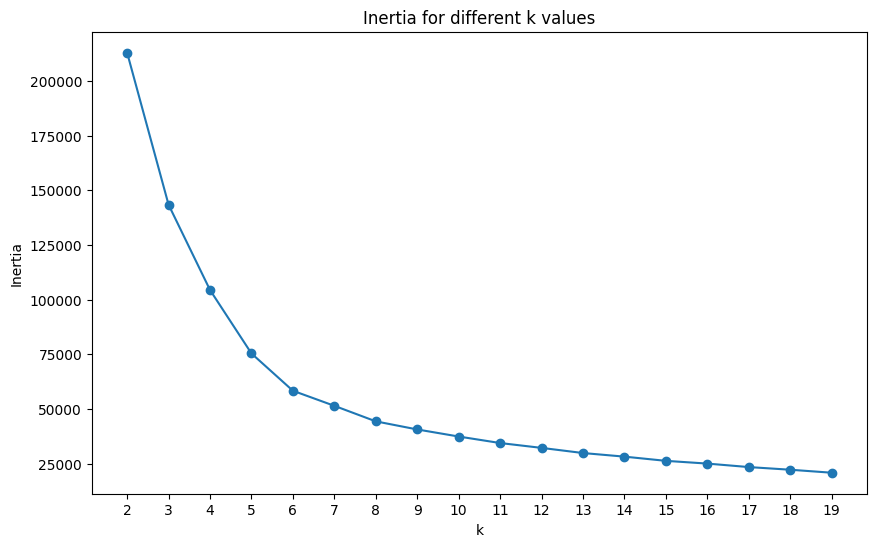

In [28]:

# Use function - four variables
k_means_inertia_plot(["Annual Income (k$)", "Spending Score (1-100)", "Age", "Gender"])

Again, not clear with all four variables. Maybe 6 clusters would be good.

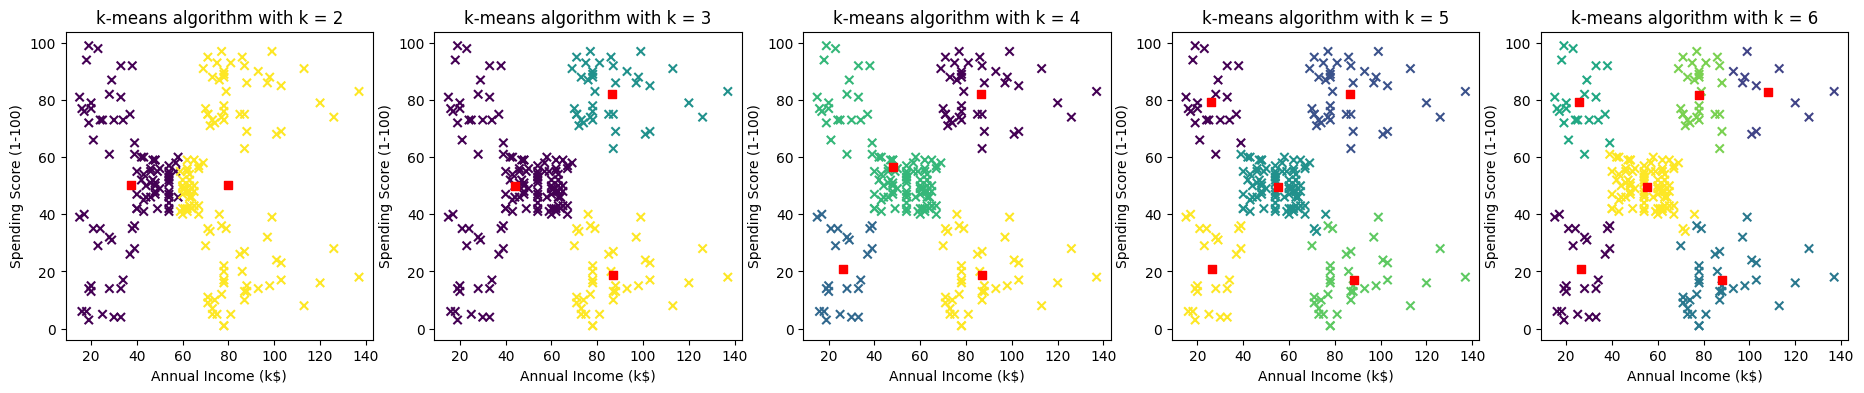

In [29]:

# Plot clusters for k = 2,3,4,5,6 and two variables
new_df = df[['Annual Income (k$)', 'Spending Score (1-100)']]

fig, ax = plt.subplots(1,5, figsize=(23,4))
for k in [2, 3, 4, 5, 6]:
  model = KMeans(n_clusters=k, n_init=10) 
  model.fit(new_df)
  centers = model.cluster_centers_
  pred = model.predict(new_df)
  ax[k-2].scatter(new_df['Annual Income (k$)'], new_df['Spending Score (1-100)'], marker='x', c=pred)
  for c in range(k):
    ax[k-2].scatter(centers[c][0], centers[c][1], color='red', marker=',')
    ax[k-2].set_title('k-means algorithm with k = ' + str(k))
    ax[k-2].set_xlabel("Annual Income (k$)")
    ax[k-2].set_ylabel("Spending Score (1-100)")

As already mentioned, the optimal number of cluster is 5 in this case. Once clustering is done, we may then use the result to label (i.e. classifiy) the customers, for example:
* Customers who earn little and spend little (the `reasonable poor`)
* Customers who earn little and spend a lot (the `senseless poor`)
* Customers who earn average and spend average (the `middle-income`)
* Customers who earn a lot and spend a lot (the `rich`). The marketing effort should focus mainly on them.
* Customers who earn a lot and spend little (the `stingy`).

With three variables and 6 clusters: [link](https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis)

In [30]:
pd.Series(pred).value_counts()

5    81
2    35
4    28
0    23
3    22
1    11
Name: count, dtype: int64

In [31]:
centers

array([[ 26.30434783,  20.91304348],
       [108.18181818,  82.72727273],
       [ 88.2       ,  17.11428571],
       [ 25.72727273,  79.36363636],
       [ 78.03571429,  81.89285714],
       [ 55.2962963 ,  49.51851852]])

We can see that the first cluster center corresponds to the middle income group of 80 consumers, the biggest cluster in our example.

### 3.3 Hierarchical clustering
We now do the same with hierarchical clustering. This yields similar results.

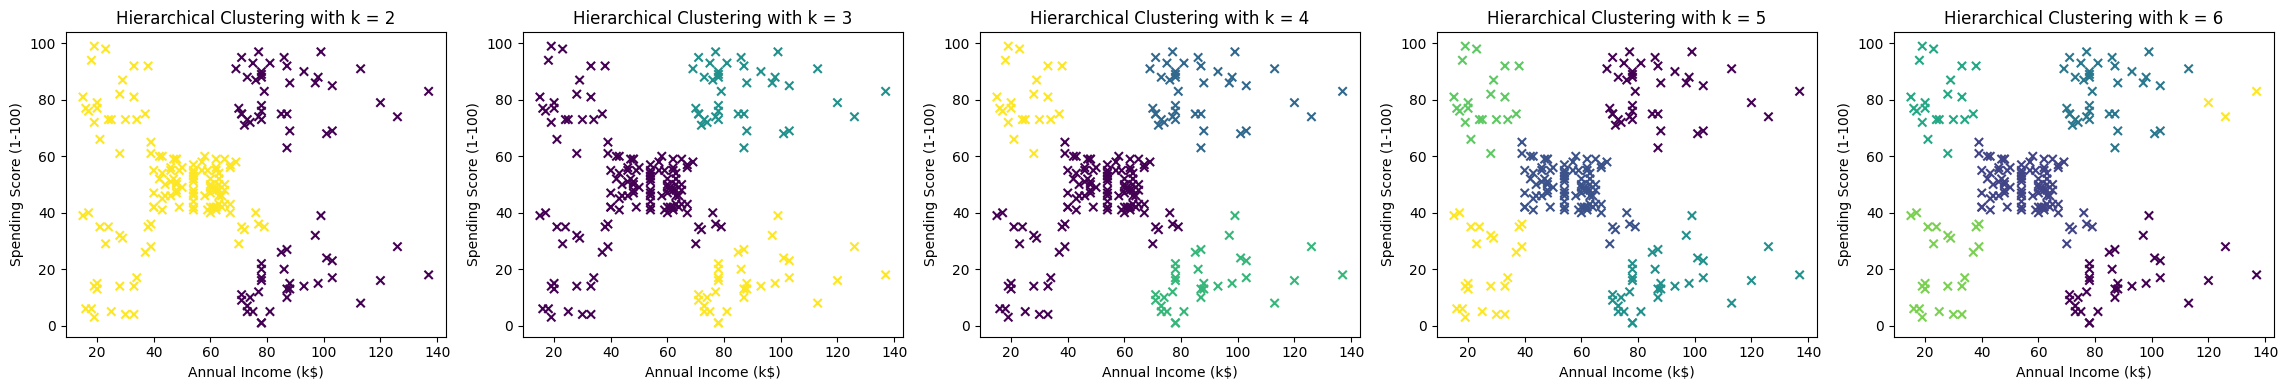

In [32]:
# Plot with different k and two variables
fig, ax = plt.subplots(1, 5, figsize=(23, 4))
for i, k in enumerate([2, 3, 4, 5, 6]):
    # Replace affinity with metric
    clustering = AgglomerativeClustering(n_clusters=k, linkage='complete', metric='euclidean')
    assignment = clustering.fit_predict(new_df)
    ax[i].scatter(new_df['Annual Income (k$)'], new_df['Spending Score (1-100)'], marker='x', c=assignment, cmap='viridis')
    ax[i].set_title(f'Hierarchical Clustering with k = {k}')
    ax[i].set_xlabel("Annual Income (k$)")
    ax[i].set_ylabel("Spending Score (1-100)")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

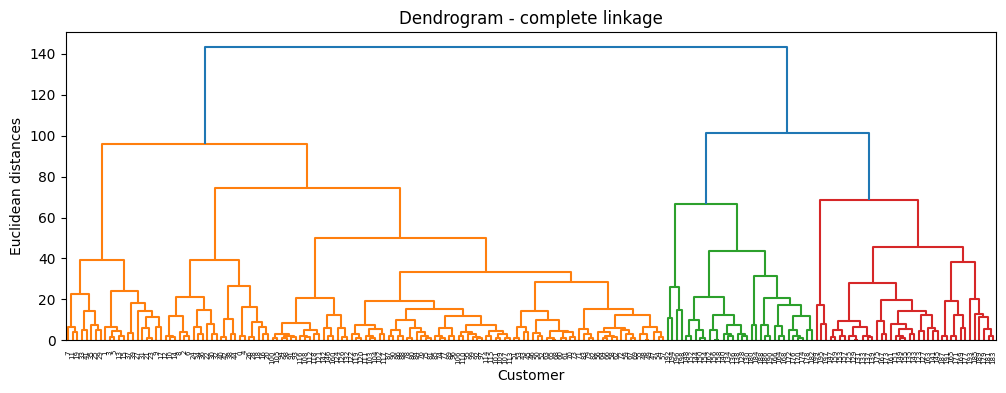

In [33]:
# Plot dendrogram - complete
plt.figure(figsize=(12,4))
dendrogram = sch.dendrogram(sch.linkage(new_df, method = 'complete'))
plt.title('Dendrogram - complete linkage')
plt.xlabel('Customer')
plt.ylabel('Euclidean distances')
plt.show()

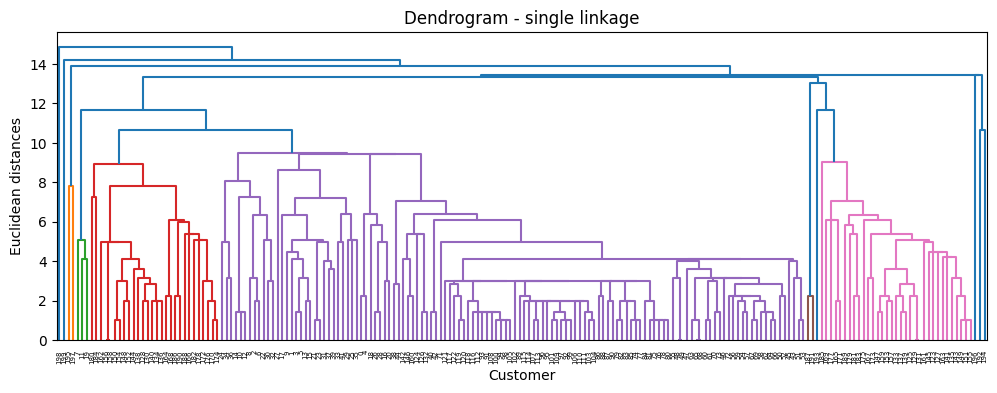

In [34]:
# Plot dendrogram - single
plt.figure(figsize=(12,4))
dendrogram = sch.dendrogram(sch.linkage(new_df, method = 'single'))
plt.title('Dendrogram - single linkage')
plt.xlabel('Customer')
plt.ylabel('Euclidean distances')
plt.show()

It does not work with single linkage. With complete linkage, we can see the 5 clusters on the dendrogram.

## 4. Clustering vs. classification
We compare classification and clustering algortihms, using a labelled data set of emails.

### 4.1 Load data

In [35]:
emails = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/12-clustering/data/spambase.csv')
emails.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


We see the emails were already vectorised and we have 57 features and a `class` feature, which classifies email into SPAM or NOT SPAM (2 classes).

In [36]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [37]:
# Base rate simplified version
print(emails["class"].value_counts())
len(emails[emails["class"] == 0]) / len(emails)

class
0    2788
1    1813
Name: count, dtype: int64


0.6059552271245382

### 4.2 Algorithms comparison: k-means vs. logistic regression



In [38]:
import os
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Suppress tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(emails.drop("class", axis=1))
y = emails["class"]

# k-means
kmeans = KMeans(n_clusters=2, n_init=10)  # Explicitly set n_init

# Logistic regression
logit = LogisticRegression(max_iter=500)  # Increase max_iter

algorithms = [kmeans, logit]

for algo in algorithms:
    # K-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Conduct k-fold cross-validation
    cv_results = cross_val_score(algo,  # Algorithm
                                  X_scaled,  # Scaled feature matrix
                                  y,  # Target vector
                                  cv=kf,  # Performance metric
                                  scoring="accuracy",  # Loss function
                                  n_jobs=-1)  # Use all CPU cores

    # Print mean
    print(f"The Mean Score is {cv_results.mean():.2f} for {algo}")


The Mean Score is 0.53 for KMeans(n_clusters=2, n_init=10)
The Mean Score is 0.93 for LogisticRegression(max_iter=500)


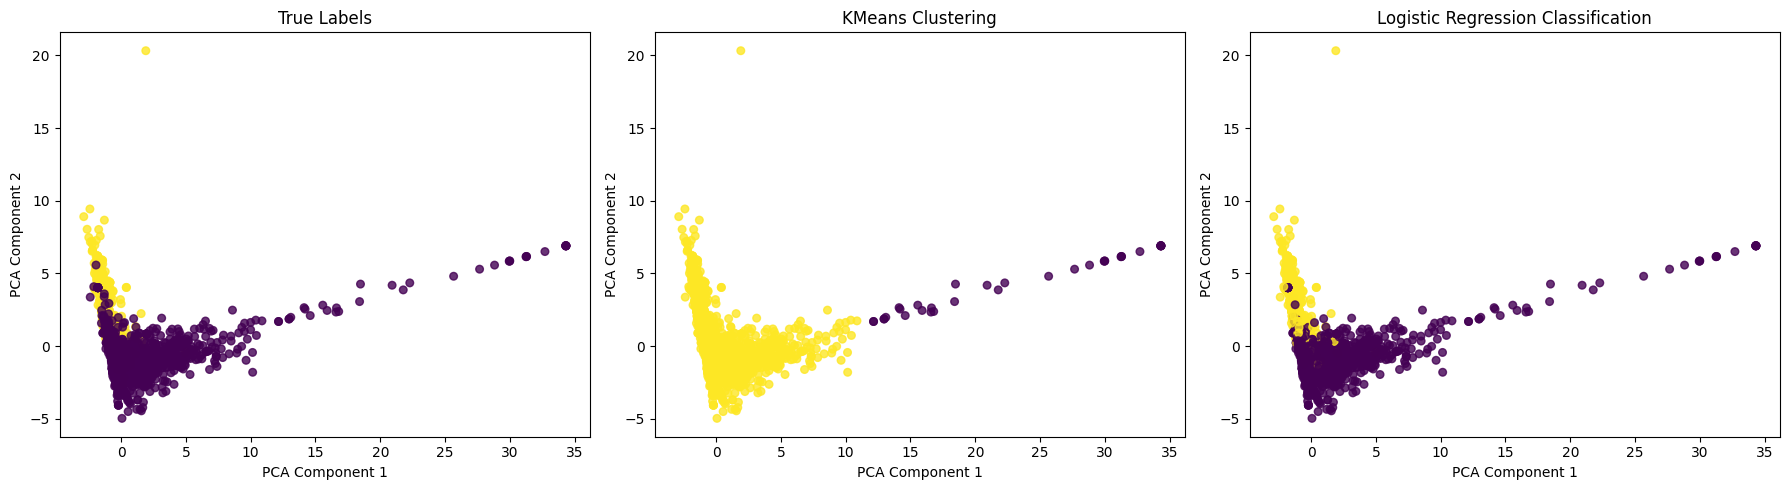

In [39]:
from sklearn.decomposition import PCA

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(emails.drop("class", axis=1))
y = emails["class"]

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Models
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
logit = LogisticRegression(max_iter=500, random_state=42)

# Fit models
kmeans.fit(X_scaled)
logit.fit(X_scaled, y)

# Predict labels
kmeans_labels = kmeans.predict(X_scaled)
logit_labels = logit.predict(X_scaled)

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot true labels
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=30, marker='o', alpha=0.8)
ax[0].set_title("True Labels")

# Plot KMeans predictions
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30, marker='o', alpha=0.8)
ax[1].set_title("KMeans Clustering")

# Plot Logistic Regression predictions
ax[2].scatter(X_pca[:, 0], X_pca[:, 1], c=logit_labels, cmap='viridis', s=30, marker='o', alpha=0.8)
ax[2].set_title("Logistic Regression Classification")

# Add axis labels
for a in ax:
    a.set_xlabel("PCA Component 1")
    a.set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


**Conclusion:** In general, classification algorithms are more precise than clustering for classification problems. This means as soon as you have labelled data, you should use classification. When there are no label or if you want to label unlabelled data, you can use clustering.

# 5. Feedbacks from the previous year
You will find bellow the dataset from last years students for the mid semester



In [40]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree  # Added cut_tree
import matplotlib.pyplot as plt

# Load and preprocess feedback data
feedbacks = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/refs/heads/master/12-clustering/data/master_survey_mid_2023.csv', index_col=0).drop_duplicates()

# Display a random sample
print(feedbacks.sample(5))


                    Why did you decide on the Master's program for "IS and Digital Innovation"?  \
Timestamp                                                                                         
11/13/2023 14:38:19  It's in the era of the time, and it mixes Inno...                            
11/13/2023 14:22:18  Because I wanted to improve my knolwdge of IT....                            
11/13/2023 14:23:35  because technologies are a major part of the f...                            
11/13/2023 14:21:11  Parce qu'il s'agit du master qui s'intéresse l...                            
11/13/2023 14:21:34  Because of the possibility to make an internsh...                            

                    Which Master's program was your next option?  \
Timestamp                                                          
11/13/2023 14:38:19                                Management BA   
11/13/2023 14:22:18     A similar master in a foreign university   
11/13/2023 14:23:35   Sustainabili

### 5.1 Can you spot clusters in the data?

In this section of the notebook, we first load and preprocess survey feedback data, focusing on textual recommendations for improvement. We then transform this text into numerical representations using two approaches: TF-IDF, which captures word frequency and importance, and SentenceTransformer embeddings, which encode the semantic meaning of the sentences. After converting the text into numerical data, we scale the features to normalize their range and prepare them for clustering.

Next, we perform hierarchical clustering on the scaled data using different linkage methods and visualize the results with dendrograms:
- **Ward linkage**: Minimizes the variance within clusters, producing compact clusters.
- **Single linkage**: Uses the minimum distance between points of different clusters, leading to elongated, chain-like clusters.
- **Complete linkage**: Considers the maximum distance between points of different clusters, resulting in tighter, spherical clusters.

This allows us to understand the hierarchical structure of the clusters and identify patterns or themes within the feedback, providing insights into common recommendations or areas for improvement.

In [41]:
%pip install sentence-transformers


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Z shape (ward): (32, 4)


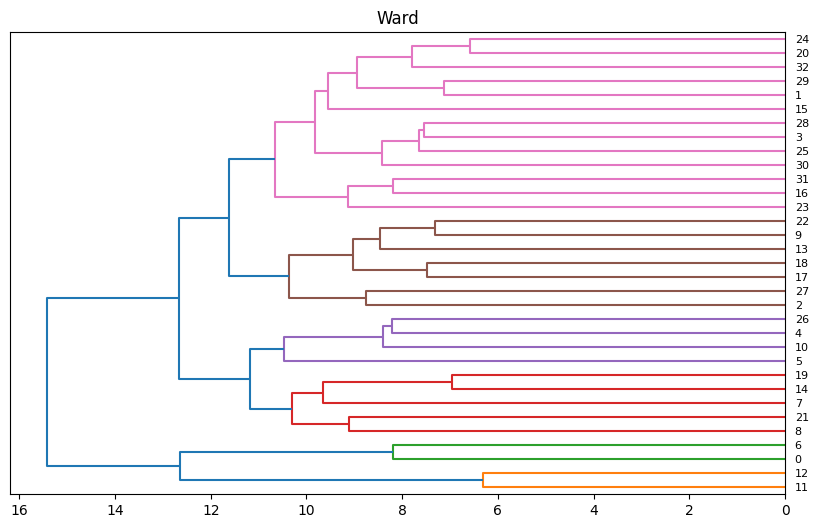

Z shape (single): (32, 4)


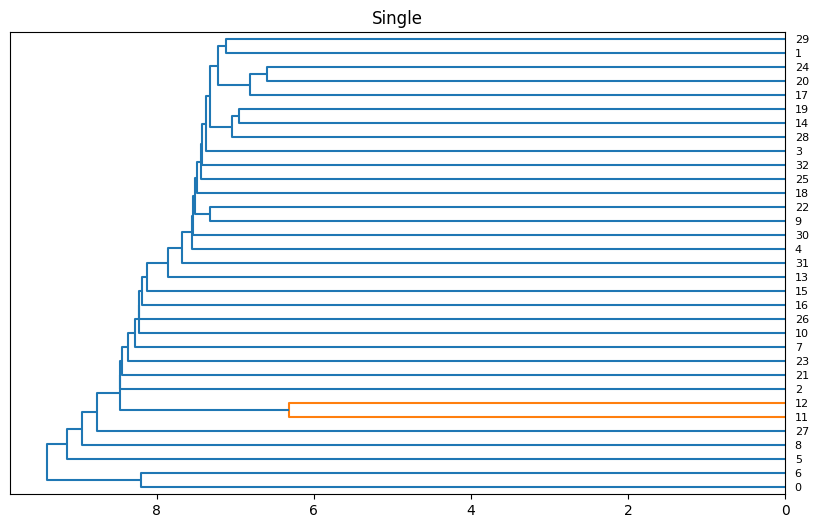

Z shape (complete): (32, 4)


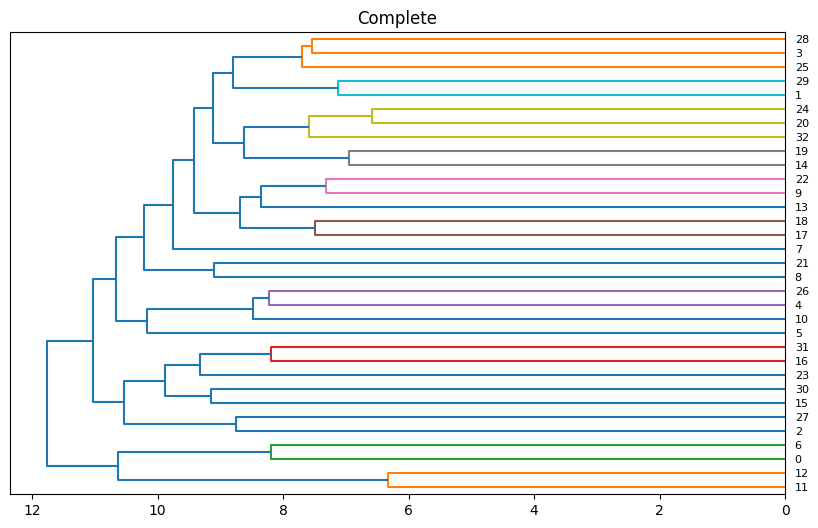

In [42]:
# Convert column to list for compatibility
recommendations = feedbacks["What are your recommendations for things to improve?"].dropna().tolist()

# TF-IDF vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words="english")
features1 = tfidf.fit_transform(recommendations)

# Sentence embedding using SentenceTransformer
model = SentenceTransformer('paraphrase-mpnet-base-v2')
features2 = model.encode(recommendations)

# Choose which features to use for clustering (TF-IDF or embeddings)
# Uncomment one of the following:
# features = features1.toarray()  # Use TF-IDF
features = features2  # Use sentence embeddings

# Scale the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Perform hierarchical clustering and plot dendrograms
methods = ['ward', 'single', 'complete']
for method in methods:
    Z = linkage(scaled_features, method)
    print(f"Z shape ({method}):", Z.shape)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(method.capitalize())
    dendrogram(Z, orientation='left')
    plt.show()


Then, we focus on applying hierarchical clustering using the **Ward method**, which minimizes variance within clusters and produces compact, well-separated groups. Once the clustering is computed, we use the `cut_tree` function to segment the hierarchical tree into a specified number of clusters. Here, we define `n_clusters=12` to divide the data into 12 distinct groups.

Next, we iterate through the clusters to display a few sample feedback responses from each group. This approach allows us to qualitatively evaluate the clustering results by examining representative recommendations in each cluster. By reviewing these samples, we can better understand the common themes or patterns within each cluster, which may highlight actionable insights or distinct areas for improvement.

In [43]:
# We will use the ward method from now on
# The cut_tree function cuts the tree at a certain height
# The n_clusters parameter is the number of clusters to find
Z = linkage(scaled_features, 'ward') # Compute the hierarchical clustering
cutree = cut_tree(Z, n_clusters=[12])

i=1
while feedbacks[cutree==[i]]["""What are your recommendations for things to improve?"""].to_list() != []:
    display(feedbacks[cutree==[i]]["""What are your recommendations for things to improve?"""].to_list()[0:3])
    i+=1


['the Software Architecture course is a bit too theoretical otherwise its ok',
 'explanation of some lessons are bad.',
 'SOA course should be improve a bit becasue I had a really hard time making the link between the lesson and the project, we misses essential information, and the support is really unintuitive and outdated (netbeans)']

['Having more links with the professional world',
 'I think the organization in general, sometime things are not clear etc…']

['Having more classes like the Digital Innovation Seminar, that is where we learn the most ',
 'I think the courses that are a bit less technical should have more concrete projects',
 "Maybe the communication. Each course have it own communication channel (Slack, moodle, email, ...) It would be time saving to centralise everything. Also not every course provide the slides before the class and it's personal but I like to work on it during the classes."]

['Group projects in general more clear',
 'Too many project at the same time',
 'projects + exam in every class']

['Un peu moins de projet de groupe qui prennent trop de temps en parallèle des cours.']

['more exercice to train ']

['Possibility to have zoom classes', 'More video for theoretical parts ']

["The level of programming is very high at the start, it should be lower. Because we weren't supposed to know that much about programming ",
 "It is maybe too early now but in a near futur, Generative AI will change how certain jobs are done. Maybe a course about how to use AI in a firm to know it's full potential ",
 "Change SOA course, it's too old. Stop making groups random (digital week), sometimes, we have to work with lasy people and it's unequal "]

['I like how it is',
 "Nothing, I like it the way it is. Even if it's a lot of work."]

['better coordination between each course for the assignments',
 'Maybe being more clear in the indication in the assignment questions']

['To be honest i dont know, its the first time I realy like to study :)',
 'Totally lost during the first weeks, as I have never worked with python or java. I would recommend to give a quick introduction to those programs, especially in python.',
 "Sometimes I will feel like it's going to fast, I don't have time to really understand all the subjects so I am learning just enough to do the exercices. "]

## References
* https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis
* https://www.kaggle.com/morecoding/hierarchical-clustering
* https://www.geeksforgeeks.org/cutting-hierarchical-dendrogram-into-clusters-using-scipy-in-python/
